**Pre-processing done**

**Transfer learning begin:**

In [1]:
from collections import Counter                     #Written by Jacob and used to calculate the true accuracy.
import numpy as np


# actual accuracy
def get_accuracy(p_data, t_data, extra_data):
    sc = 0
    if extra_data is None:
        for i in range(len(p_data)):
            if p_data[i] == t_data[i]:
                sc += 1

        return sc / len(p_data)
    else:
        counter = -1
        for i in range(len(extra_data)):
            is_good = True
            for j in range(extra_data[i]):
                counter += 1
                is_good &= p_data[counter] == t_data[counter]
            if is_good:
                sc += 1
        return sc / len(extra_data)

In [3]:
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
  
        
DOWNLOAD_MNIST = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
torch.manual_seed(1)
# load the feature network
feature_net = torch.load('/content/drive/MyDrive/fnet.pt')    
# create 3 random images of size 1x28x28
images = torch.rand(3, 1, 28, 28)
# compute the features for the 3 random images
feature_net(images).shape # this shape should be 3x84  
#Seems like we use a CNN to extract the features of the Images. Sounds like the purpose of it is like PCA or other similar methods.

torch.Size([3, 84])

In [5]:
from torchvision.datasets import MNIST

mnist_tr = MNIST('~/.torchvision', train=True, download=True)
x_train, y_train = mnist_tr.data, mnist_tr.targets
mnist_ts = MNIST('~/.torchvision', train=False, download=True)
x_test, y_test = mnist_ts.data, mnist_ts.targets


x_train = x_train.reshape(x_train.shape[0], 1,28, 28)  #Reshape the image to input into the feature net successfully
x_test = x_test.reshape(x_test.shape[0],1,28, 28)
x_train = x_train/255
x_test = x_test/255
x_train = feature_net(x_train)
x_test = feature_net(x_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
x_train1nb, y_train1nb = mnist_tr.data, mnist_tr.targets    #Reload the MNIST dataset as the x_train... and pre-process.
x_train1nb = x_train1nb.reshape(len(x_train1nb), -1).float()
Xx= x_train1nb.detach().numpy()
Yy = y_train1nb.detach().numpy()
x_test1nb, y_test1nb = mnist_ts.data, mnist_ts.targets
x_test1nb = x_test1nb.reshape(len(x_test1nb), -1).float()
Xxt= x_test1nb.detach().numpy()
Yyt = y_test1nb.detach().numpy()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.torchvision/MNIST/raw/train-images-idx3-ubyte.gz to /root/.torchvision/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.torchvision/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.torchvision/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.torchvision/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.torchvision/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.torchvision/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.torchvision/MNIST/raw

torch.Size([60000, 84]) torch.Size([60000])
torch.Size([10000, 84]) torch.Size([10000])


In [6]:
import sklearn
X = x_train.detach().numpy()                 #Pre-process the input to apply NB classifier.
Y = y_train.detach().numpy()
Xt = x_test.detach().numpy()
Yt = y_test.detach().numpy()

In [7]:
from sklearn.ensemble import RandomForestClassifier     #Take the features extracted as input
rf = RandomForestClassifier(max_depth=3, random_state=42)
rf.fit(X,Y)
print('The training set accuracy is','%.5f'%rf.score(X,Y))     #rf is for feature net model

The training set accuracy is 0.99517


In [8]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(max_depth=3, random_state=42)              
rf2.fit(Xx,Yy)
print('The training set accuracy is','%.5f'%rf2.score(Xx,Yy))        #rf2 is for simple model

The training set accuracy is 0.74327


In [9]:
import h5py                                  #Load pre-processed data
# Open the file as readonly
h5f = h5py.File('/content/drive/MyDrive/Resizedata_bugfixed.h5', 'r')

# Load the training, test and validation set
x_train = h5f['x_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['x_test'][:]
y_test = h5f['y_test'][:]

# Close this file
h5f.close()

print('Training set', x_train.shape, y_train.shape)
print('Test set', x_test.shape, y_test.shape)

Training set (73257, 28, 28) (73257,)
Test set (26032, 28, 28) (26032,)


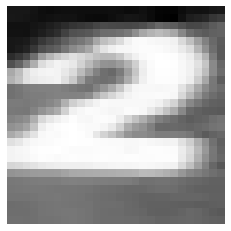

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
plt.imshow(x_train[2],cmap='gray')
plt.axis('off')
plt.savefig('fig1_stat3007_talk.png')

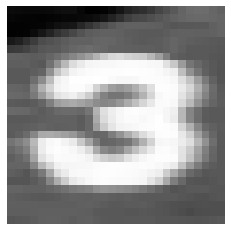

In [ ]:
plt.imshow(x_train[3],cmap='gray')
plt.axis('off')
plt.savefig('fig2_stat3007_talk.png')

In [10]:
x_test2nb = x_test.reshape(len(x_test), -1)
x_test2nb.shape

(26032, 784)

In [11]:
print('The testset one-accuracy is','%.5f'%rf2.score(x_test2nb,y_test))

The testset one-accuracy is 0.06377


In [12]:
x_test2nbe = feature_net(torch.Tensor(x_test.reshape(len(x_test),1,28,28)/255))
x_test2nbe = x_test2nbe.detach().numpy()

In [13]:
print('The testset one-accuracy after fnet is','%.5f'%rf.score(x_test2nbe,y_test))

The testset one-accuracy after fnet is 0.19057


In [14]:
p =rf2.predict(x_test2nb)

In [15]:
file = open("/content/drive/MyDrive/test_labels.txt", "r")
stringList = file.readlines()
extra_data = []
for i in range(len(stringList)):
  extra_data.append(len(stringList[i])-1)

In [16]:
print('the test set true accuracy is: ', get_accuracy(p,y_test,extra_data))

the test set true accuracy is:  0.02203856749311295


In [17]:
p2 = rf.predict(x_test2nbe)

In [18]:
print('the test set true accuracy after fnet is: ', get_accuracy(p2,y_test,extra_data))

the test set true accuracy after fnet is:  0.06489133761861035
